<h2> Importations of libraries

In [1]:
#Importing libraries
import requests
import xmltodict
from io import BytesIO

import geopandas as gpd
from pyproj import Proj
from shapely import wkt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<h2> Stating fishing locations

In [2]:
#Stating the fishing spots and tidal information for my designated harbour
locations = [
    ['Festvåg',67.4359,14.7331],
    ['Fjære',67.5031,14.7213],
    ['Mjønes',67.2900,14.9959],
    ['Valnesfjord', 67.3003,15.1815],
    ['Misvær',67.121,14.9912],
    ['Valnes', 67.1827,14.4709],
    ['Evjen',67.07718,14.4060],
    ['Saksenvika',67.098448, 15.464130]
]

harbour = 'bod%C3%B8'

<h2> Retrieve wind data

In [3]:
#A function that retrieves wind data from Meterologisk institutt


def retrieve_wind_data(inputdata):
    #Retrieving the data from www
    url = 'https://api.met.no/weatherapi/locationforecast/2.0/classic?lat='+str(inputdata[2])+'&lon='+str(inputdata[1])
    headers = {
        'User-Agent':'Fishing_test'
    }
    response = requests.get(url, headers=headers)
    
    #Transfomring it into a dataframe
    data = xmltodict.parse(response.content)    
    dfw1 = pd.DataFrame(data['weatherdata']['product']['time'])
    del dfw1['@datatype']
 
    #Retrieving wind data, excluding rain and other data.
    weather = []  #15
    for i in range(0,len(dfw1),1):
        date = dfw1['@from'][i]
        number = len(dfw1['location'][i])
        item = pd.DataFrame(dfw1.iloc[i]).transpose().reset_index()
        del item['index']
        if number >= 12:
            weather.append(item)
    dfw2 = weather[:24]
    
    #Setting up windspeed and -direction in an dataframe
    direction = []
    speed = []
    for i in range(0,len(dfw2),1):
        direction_item = dfw2[i]['location'][0]['windDirection']['@name']
        speed_item = round(float(dfw2[i]['location'][0]['windSpeed']['@mps']) * 1.609)

        direction.append(direction_item)
        speed.append(speed_item)

    time_item  = int(dfw2[0]['@from'][0][11:13])
    time = np.concatenate((np.linspace(0,23,24)[time_item:],
                           np.linspace(0,time_item-1,time_item)),
                           axis=None)

    #Putting data into columns
    finaldf['Time'] = time
    finaldf['Wind_dir'+inputdata[0]] = direction
    finaldf['Wind_spd'+inputdata[0]] = speed

<h2> Retrieve tidal data

In [4]:
#A function that retrieves tidal data from Bodø harbour


def retrieve_tidal_data(inputdata):
    
    #Retrieving the data from www
    url =  'https://api.met.no/weatherapi/tidalwater/1.1/?harbor='+inputdata
    response = requests.get(url)
    rawdata = response.content
    
    #Transform to df
    df = pd.read_csv(BytesIO(rawdata))
    df = df.loc[5:].reset_index()
    del df['index']
    
    #First handling
    cumlist = []
    for i in range(0,len(df),1):
        sel = df.loc[i][0].split()
        cumlist.append(sel)

    df2 = pd.DataFrame()
    for i in range(0,len(cumlist),1):
        df2[i] = cumlist[i]

    #Second handling
    dft =  df2.transpose().rename(columns=df2.transpose().loc[0]).drop(labels=0,axis=0)
    return  dft

<h2> Combine the data

In [5]:
#A function that combines weather and tidal data into the same dataframe


def combine_weather_tidal(dft):
    dft['TIM'] = pd.to_numeric(dft['TIM'])
    dft['TOTAL'] = pd.to_numeric(dft['TOTAL'])
    start_hour = finaldf['Time'][0]
    tides = dft.loc[start_hour:start_hour+23]['TOTAL'].reset_index()
    del tides['index']
    finaldf['Tides'] = tides

In [6]:
#A function that creates the dataframe


finaldf = pd.DataFrame()

def create_df():
    for i in range(0,len(locations),1):
        retrieve_wind_data(locations[i])
    
    tidal_data = retrieve_tidal_data(harbour)
    
    combine_weather_tidal(tidal_data)
    finaldf['Measurment'] = np.linspace(530000,550000,24)

create_df()

In [7]:
# # This function is for reducing the size of the original dataframe
# # collected from geonorge.no.  The reduced dataframe will be retrieved
# # in the next section of code

# file = open('kommuner2021.json')
# norwayMap = gpd.read_file(file)
# counties = ['Bodø ','Beiarn ','Fauske – Fuossko','Gildeskål ','Saltdal ']

# counties_list = []
# for i in range(0,len(counties),1):
#     item = norwayMap.loc[norwayMap['Kommunenavn']==counties[i]]
#     counties_list.append(item)

# dfmap = norwayMap.copy()  

# counties = ['Bodø ','Beiarn ','Fauske – Fuossko','Gildeskål ','Saltdal ']
# for i in range(0,len(dfmap),1):
#     sel = []
#     for j in range(0,len(counties),1):
#         if counties[j] == dfmap['Kommunenavn'][i]:
#             sel.append(1)
#         else:
#             sel.append(0)
#     if np.sum(sel) == 0:
#         dfmap = dfmap.drop(index=i, axis=0)

In [9]:
# gdf = gpd.GeoDataFrame(dfmap)
# gdf = gdf.set_crs(crs="EPSG:4326", allow_override=True)
# gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)
# gdf.to_csv('geodata.csv', index=False)

In [10]:
dfmap = pd.read_csv('geodata.csv')
        
dfmap['geometry'] = dfmap['geometry'].apply(wkt.loads)
my_geo_df = gpd.GeoDataFrame(dfmap, geometry='geometry')

<h2> Specifying bevahioural trends for windmarkers

In [11]:
#Specifying bevahioural trends for windmarkers


wind_marker = pd.DataFrame({
    'Dir':['N','NW','W','SW','S','SE','E','NE'],
    'Ang':[180,225,270,315,0,45,90,135],
    'x_move':[0,-.5,-1,-.5,0,.5,1,.5],
    'y_move':[1,.5,0,-.5,-1,-.5,0,.5]
})

color_frame = pd.DataFrame()
for i in range(1,15,1):    
    if i <= 4:
        color_frame[int(i)] = ['green']
    elif i <= 7:
        color_frame[int(i)] = ['orange']
    else:
        color_frame[int(i)] = ['red']

<h2> Plotting the fishing weather

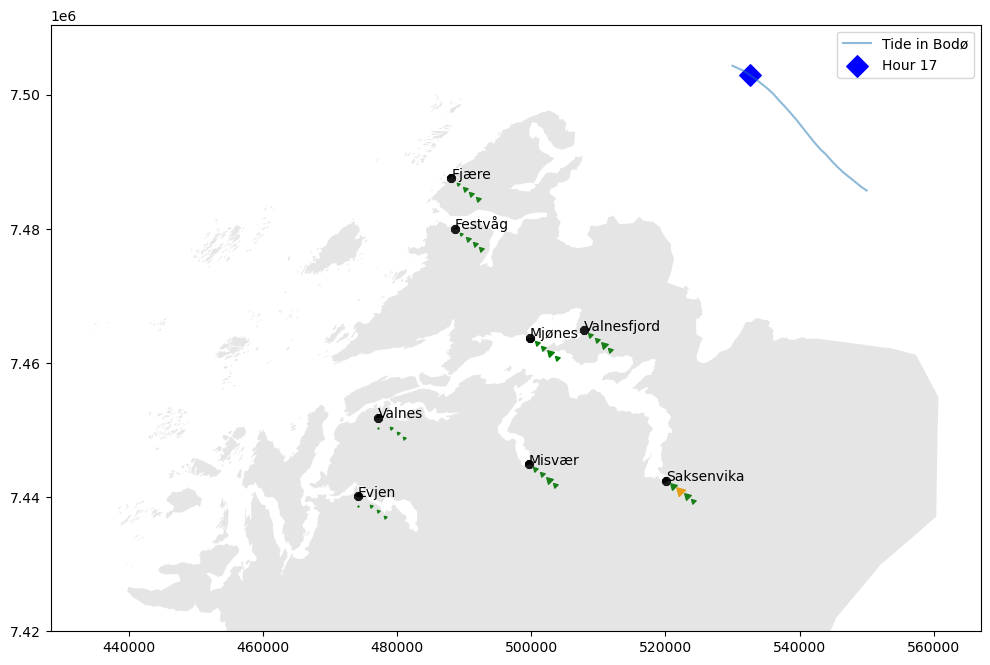

In [12]:
#Specifiying which hour I want the fishing weather data from
h = 17
#Specify how many hours ahead in time you want to see data from
ahead = 4
#Specify the interval of seeing data, e.g: every hour = 1, every second hour = 2
interval = 1





#Creating the fishing weather plot


p = Proj(proj='utm', zone=33, ellps='WGS84')
fig, ax = plt.subplots(figsize=(12,10))

# Location plot
for i in range(0,len(locations),1):
    x,y  = p(locations[i][2],locations[i][1])
    ax.scatter(x=x, y=y,color='black', marker='8')
    ax.text(x,y,locations[i][0])
    

#Wind plot, number of j is for number of hours
for j in range(0,ahead,interval):
    h_index = finaldf.loc[finaldf['Time'] == h].index[0]+j
    for i in range(0,len(locations),1):
        
        x =  locations[i][2]
        y = locations[i][1]
        x,y = p(locations[i][2],locations[i][1])
        
        a =['Wind_dir'+locations[i][0]]
        a2 = ['Wind_spd'+locations[i][0]]
        
        b = finaldf.loc[h_index]
        
        c = b[a][0]
        c2 = b[a2][0]

        x_move = wind_marker.loc[wind_marker['Dir']== c]['x_move'].reset_index()['x_move'][0]
        y_move = wind_marker.loc[wind_marker['Dir']== c]['y_move'].reset_index()['y_move'][0]

        ax.scatter(x+x_move*(2000*(j+1)),y+y_move*(1500*(1+j)),
                  marker= (3,1,wind_marker.loc[wind_marker['Dir'] == c].reset_index()['Ang'][0]),
                    s = c2**2.5,            
                   color = color_frame[c2][0] )
        
#Map plot
my_geo_df.plot(ax=ax, color='grey', alpha=.2)
        
# Tidal *plot
ax.plot(finaldf['Measurment'], finaldf['Tides']*10000+7490000,alpha=.5,label='Tide in Bodø')
ax.scatter(x=finaldf.loc[finaldf['Time'] == h]['Measurment'],
           y=(finaldf.loc[finaldf['Time'] == h]['Tides']*10000+7490000)
           ,marker='D', s=120, label='Hour '+str(h),color='blue')

               
plt.ylim(7420000)
plt.legend()
plt.show()